In [1]:
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor, plot_tree, plot_importance

data_path = 'C:/Users/mkshi/Documents/GitHub/House-pricing-Kaggle-challenge'

## load and inspect the data

In [2]:
df = pd.read_csv(os.path.join(data_path,'train.csv'))
print(df.shape)
df.head(3)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
pd.options.display.float_format = "{:,.2f}".format
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,"1,460.00","1,460.00","1,201.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,452.00","1,460.00",...,"1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00"
mean,730.50,56.90,70.05,"10,516.83",6.10,5.58,"1,971.27","1,984.87",103.69,443.64,...,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,"2,007.82","180,921.20"
std,421.61,42.30,24.28,"9,981.26",1.38,1.11,30.20,20.65,181.07,456.10,...,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,"79,442.50"
min,1.00,20.00,21.00,"1,300.00",1.00,1.00,"1,872.00","1,950.00",0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,"2,006.00","34,900.00"
25%,365.75,20.00,59.00,"7,553.50",5.00,5.00,"1,954.00","1,967.00",0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,"2,007.00","129,975.00"
50%,730.50,50.00,69.00,"9,478.50",6.00,5.00,"1,973.00","1,994.00",0.00,383.50,...,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,"2,008.00","163,000.00"
75%,"1,095.25",70.00,80.00,"11,601.50",7.00,6.00,"2,000.00","2,004.00",166.00,712.25,...,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,"2,009.00","214,000.00"
max,"1,460.00",190.00,313.00,"215,245.00",10.00,9.00,"2,010.00","2,010.00","1,600.00","5,644.00",...,857.00,547.00,552.00,508.00,480.00,738.00,"15,500.00",12.00,"2,010.00","755,000.00"


In [4]:
# Drop ID
df.drop('Id',axis=1, inplace=True)

### Get a sense of how many missing values are in the data

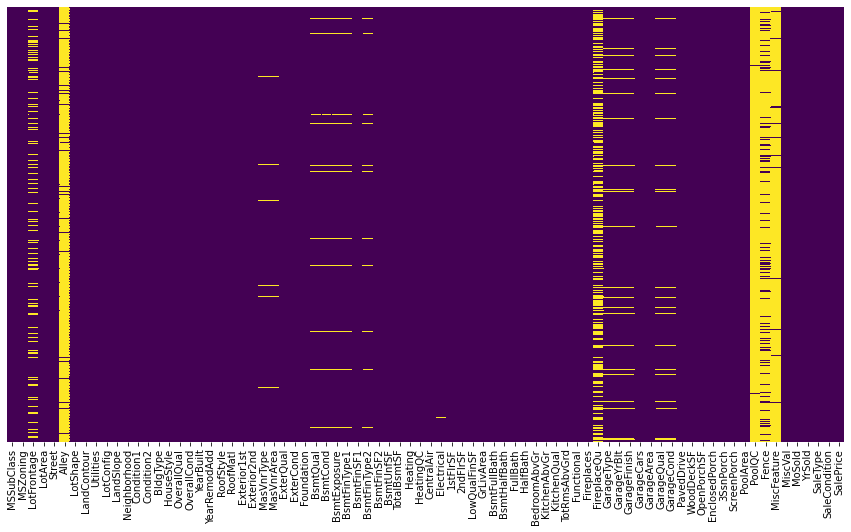

In [5]:
# plot heatmap for detecting null values
plt.figure(figsize=(15,8))
sns.heatmap(df.isnull(),cmap="viridis",yticklabels=False,cbar=False);

#### Drop features that have too many missing values

In [6]:
threshold = 0.15
features_with_many_missing_values = [i for i in df.columns if df[i].isnull().sum()>len(df)*threshold]
df.drop(features_with_many_missing_values,axis=1, inplace=True)
df.shape

(1460, 74)

### Go over the features and manually change categorical values of an ordinal-scale to numerical values
#### link to data description: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [7]:
def ordinal_from_categorical_to_numeric(df):
    df['Utilities'].replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)
    df['LandSlope'].replace({'Gtl':1, 'Mod':2, 'Sev':3}, inplace=True)
    df['ExterQual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['ExterCond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['BsmtQual'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True) # rethink: NA could be as good as poor quality
    df['BsmtCond'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['BsmtExposure'].replace({'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)
    df['BsmtFinType1'].replace({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
    df['BsmtFinType2'].replace({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
    df['HeatingQC'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['CentralAir'].replace({'N':0, 'Y':1}, inplace=True)
    df['KitchenQual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['GarageFinish'].replace({'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)
    df['GarageQual'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['GarageCond'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['PavedDrive'].replace({'N':1, 'P':2, 'Y':3}, inplace=True)
    
    return df

df = ordinal_from_categorical_to_numeric(df)
print(df.shape)

# Additional manual sanity-checks
if sum(df['YearBuilt']<=df['YearRemodAdd']) < len(df):
    raise Exception(len(df)-sum(df['YearBuilt']<=df['YearRemodAdd']), ' houses were remodeled before being built, see YearBuilt and YearRemodAdd')
    
# Manually scatter and/or check details, if needed:
# sns.scatterplot(x=df['****'], y='SalePrice',data=df_temp, legend=True)
# df[['PavedDrive']].describe()

(1460, 74)


#### Deal with missing values

In [8]:
def deal_with_missing_values(df):
    features_that_have_nulls = [i for i in df.columns if df[i].isnull().sum()>0]
    corrMatrix = df.corr()
    for i in features_that_have_nulls:
        if (df[i].dtype == np.int64) or (df[i].dtype == np.float64):
            # find the column that best correlates with the column that has missing values
            best_corr = corrMatrix[[i]].nlargest(2,[i]).transpose().columns[1] #take the 2nd best (the #1 best corr will be with itself)
            df[i] = df[i].fillna(df.groupby(best_corr)[i].transform('mean'))
        else:
            # for categorical features, fill in with the common value
            df[i].fillna(df[i].value_counts().index[0], inplace=True)
    return df

deal_with_missing_values(df)
print(df.shape)

(1460, 74)


#### convert categorical variables to dummy variables

In [9]:
df = pd.get_dummies(df)
df.head()
print(df.shape)

(1460, 221)


#### Normalize (min-max normalization)

In [10]:
df=(df-df.min())/(df.max()-df.min())

#### Drop featuers with very low variance (where 1 value constitutes over n% of the data)

In [11]:
n = 98 # %
features_with_low_variance = [i for i in df.columns if df.groupby(i).count().max()[0] > n/100*len(df)]
df.drop(features_with_low_variance,axis=1, inplace=True)
df.shape

(1460, 128)

#### * Done preprocessing *

## Modeling the data

In [12]:
# Split train and test sets - though I don't need to, I have a test set and I get the sccore from the Kaggle site....
y = df['SalePrice']
X = df.drop(['SalePrice'],1)
# random split to train (70%), validation (15%) and self-test (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

### XGBoosting

In [13]:
xg_model = XGBRegressor(n_estimators=70, max_depth=3, learning_rate=0.25, subsample=0.8)
xg_model.fit(X_train, y_train)

# Test the model's training and cross validation score
cv_scores = cross_val_score(xg_model, X_train, y_train, cv=10)
train_score = xg_model.score(X_train, y_train)
print('Training score: ', train_score ,'\n10-fold cross validation mean score: ', cv_scores.mean())

Training score:  0.9755063799119486 
10-fold cross validation mean score:  0.874550767707062


#### Visualize single DTs to gain some insight into the boosting process:

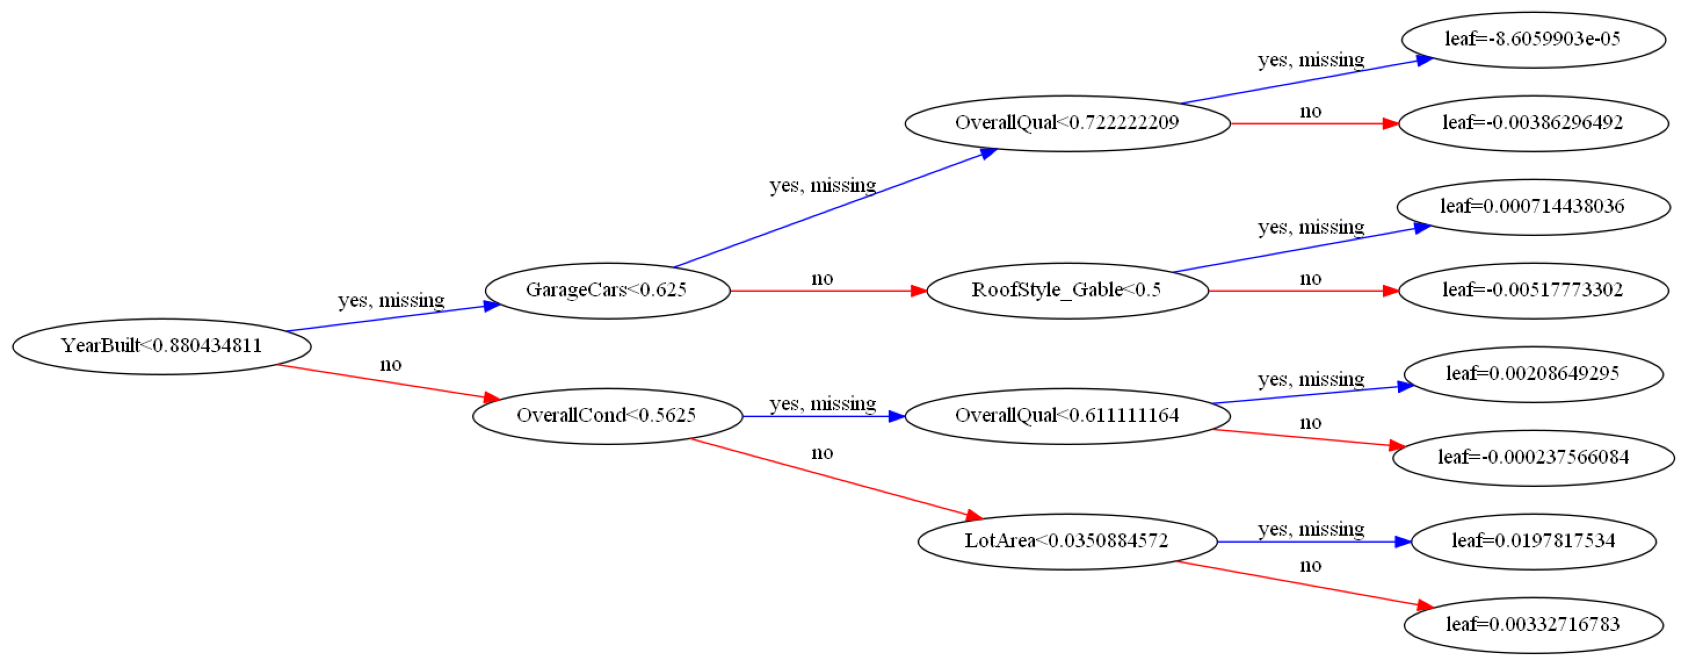

In [14]:
plot_tree(xg_model, num_trees=50, rankdir='LR') # note: num_trees is the ordinal number of the tree plotted
fig = plt.gcf()
fig.set_size_inches(30, 30)

In [15]:
# from sklearn.model_selection import validation_curve

# # Optimize hyperparameters
# param_to_optimize = 'max_depth'


# param_range = np.arange(2,40,1)
# train_scores, cv_scores = validation_curve(
#     XGBRegressor(n_estimators=70, learning_rate=0.25, subsample=0.8), 
#     X_train, y_train,
#     param_name=param_to_optimize, param_range=param_range, 
#     scoring='neg_mean_squared_error', n_jobs=2)
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# cv_scores_mean = np.mean(cv_scores, axis=1)
# cv_scores_std = np.std(cv_scores, axis=1)

# # plot
# plt.title('Validation Curve with XGBoosting')
# plt.xlabel(param_to_optimize)
# plt.ylabel("Score")
# # plt.ylim(0.0, 1.1)
# lw = 2
# plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
# plt.fill_between(param_range,
#     train_scores_mean - train_scores_std,
#     train_scores_mean + train_scores_std,
#     alpha=0.2, color="darkorange", lw=lw)
# plt.plot(param_range, cv_scores_mean, label="Cross-validation score", color="navy", lw=lw)
# plt.fill_between(param_range, 
#     cv_scores_mean - cv_scores_std,
#     cv_scores_mean + cv_scores_std,
#     alpha=0.2, color="navy", lw=lw)
# plt.legend(loc="best")
# plt.show()

### Optimize features according to their importance

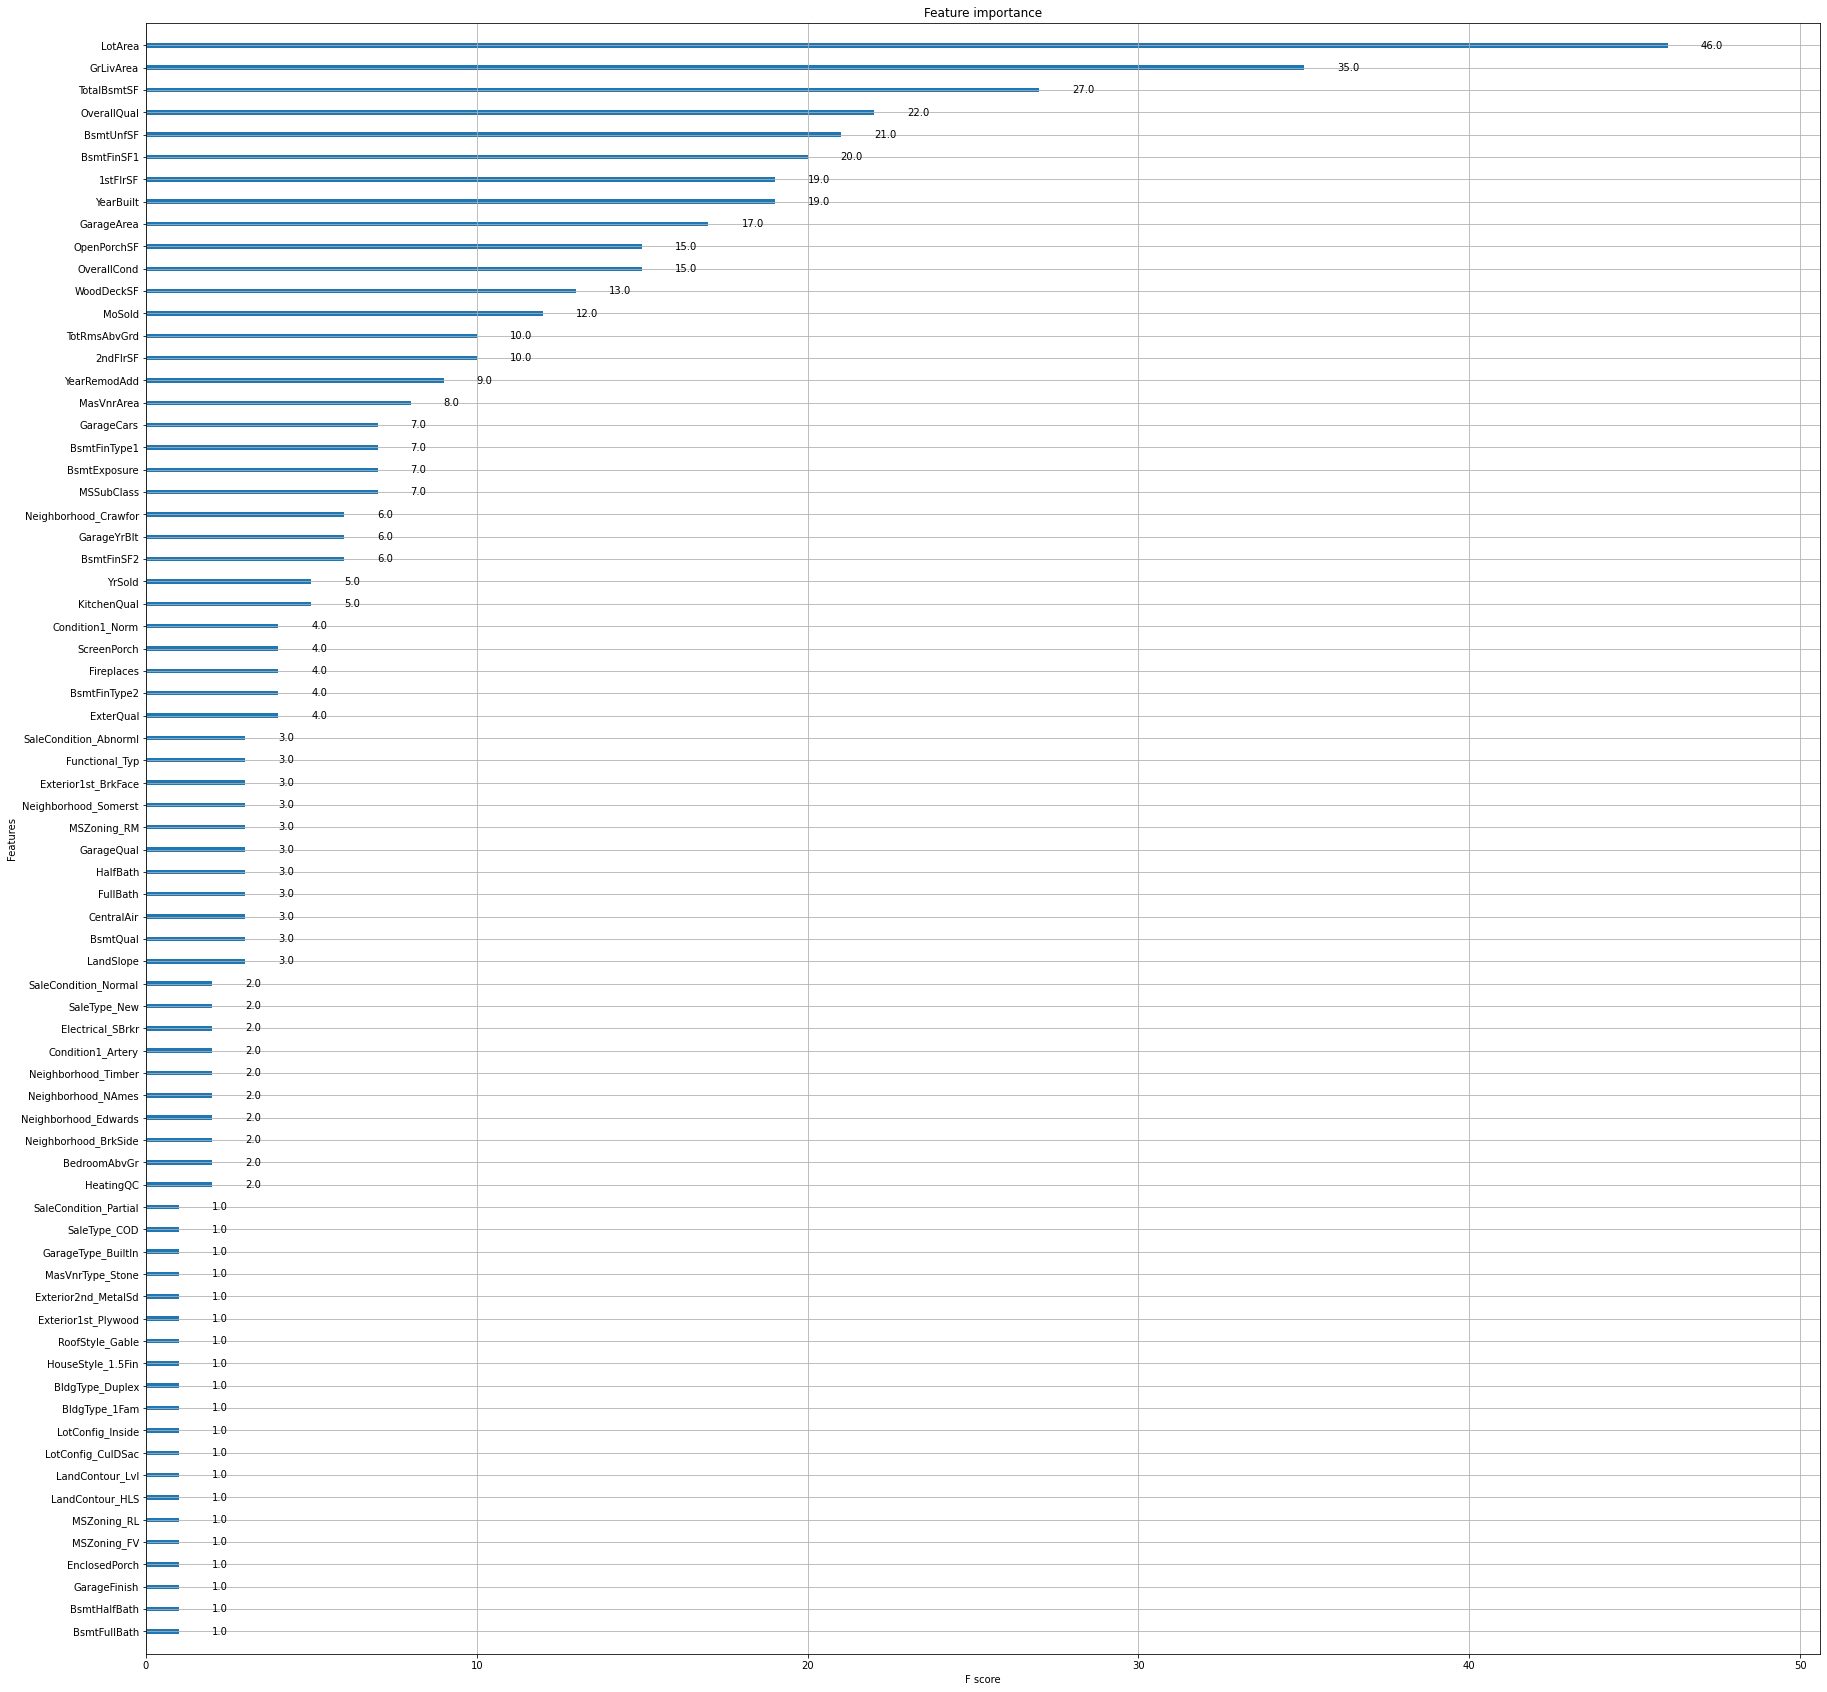

In [16]:
plot_importance(xg_model)
fig = plt.gcf()
fig.set_size_inches(30, 30)

feature_importance = np.sort(xg_model.feature_importances_)

## Prepare test data for prediction

In [17]:
# load the data
df_test = pd.read_csv(os.path.join(data_path,'test.csv'))
print(df_test.shape)
# df_test.info()

df_test = ordinal_from_categorical_to_numeric(df_test)
# df_test.info()
Id = df_test[['Id']]
df_test.drop(['Id',*features_with_many_missing_values] ,axis=1, inplace=True)
print(df_test.shape)

# # deal with missing values
# df_test = deal_with_missing_values(df_test)

# change categorical to dummies
df_test = pd.get_dummies(df_test)
print(df_test.shape)        

# Drop unwanted features
df_test.drop(features_with_low_variance ,axis=1, inplace=True, errors='ignore')
print(df_test.shape)


(1459, 80)
(1459, 73)
(1459, 206)
(1459, 127)


## Create predictions for the test data

In [18]:
test_predictions = xg_model.predict(df_test)
# save in submission format
results = Id.assign(SalePrice = test_predictions) # assign predictions to Id
results.to_csv(os.path.join(data_path,'submission.csv'), index=False) # write the final dataset to a csv file.